# Tutorial on Qsyst class

The **Qsyst** class is used to model an arbitrary number of bosonic modes. Before going through this tutorial, please read the [README.md](../README.md) file to learn how to install the required packages and set up a virtual environment. There is also a section on the structure of the **gausstorch** package.

To understand how gaussian states are simulated, read **section 5.3** of my thesis manuscript.

On initialization, the **Qsyst** class has one required parameter: **init_pars**. It is a **dict** containing all of the physical drive, coupling and dissipation parameters. It also contains input encoding parameters.

Here is how encoding of an input works. First, we choose an encoding parameter $\theta_{\text{enc}}$: either the drive **eA**, the photon conversion **g**, or the two-mode squeezing rates **gs**. Let $\mathbf{x}$ be an input vector *of the same dimension $d$ as the encoding parameter $\theta_{\text{enc}}$*.

- To encode an input $\mathbf{x}$ into the *amplitude* of the encoding parameter $\theta_{\text{enc}}$ (**theta** variable in the code), we use the relation
$$
\theta_{\text{enc}}(\mathbf{x}) = \theta_0 \odot \mathbf{x} + \theta_{\text{bias}},
$$
where $\theta_0, \theta_{\text{bias}} \in \mathbb{C}^d$, and $\odot$ is the element-wise vector product. In the **init_pars** dictionnary, the real and imaginary values of $\theta_{\text{bias}}$ are specified, while **$\theta_0$ takes the default value of the encoding parameter**.

- To encode an input $\mathbf{x}$ into the *phase* of the encoding parameter $\theta_{\text{enc}}$, we instead use the relation
$$
\theta_{\text{enc}}(\mathbf{x}) = \theta_0 \odot e^{i\phi(\mathbf{x})} + \theta_{\text{bias}}\\
\phi(\mathbf{x}) = \phi_0 \odot \mathbf{x} + \phi_{\text{bias}},
$$
where $\theta_0, \theta_{\text{bias}}$ are the same as in amplitude encoding, and $\phi_0, \phi_{\text{bias}} \in \mathbb{R}^d$. To avoid redundancy in encoding values, the user should at least set $\phi_0 + \phi_{\text{bias}} < \pi$.

Here is an example of an **init_pars** below, with explication of each parameter. We note that every unit is S.I (so seconds for time, $\text{Hz}$ for frequency etc.), and the unit of drive amplitudes is $\sqrt{\text{Hz}}$.

In [16]:
# Required imports
import torch
from gausstorch.libs.qsyst import Qsyst, init_pars_default

M = 3
g_shape = M * (M - 1) // 2  # number of possible couplings for a given coupling type (photon conversion or two-mode squeezing)
eA = M * 1e5
init_pars = {
    'M': M,  # Number of modes
    # learnable parameters
    # Output weight matrix, for the linear classifier on a reservoir output. Only use in child classes for learning, so unused here.
    'W_0': torch.ones(1),
    # Output weight bias, for the linear classifier on a reservoir output. Only use in child classes for learning, so unused here.
    'W_bias': torch.zeros(1),
    # Real value of the encoding parameter bias, called 'theta'. Set to 0 by default.
    'theta_bias_real': torch.zeros(1),
    # Imag value of the encoding parameter bias, called 'theta'. Set to 0 by default.
    'theta_bias_imag': torch.zeros(1),
    # (Real) value of the phase encoding parameter, if phase encoding is chosen.
    'phi_0': torch.zeros(1),
    # (Real) bias value of the phase encoding parameter, if phase encoding is chosen.
    'phi_bias': torch.zeros(1),
    # detuning of the drives with respect to the mode resonance frequency.
    'detuning': torch.zeros(M),
    # Real and imaginrary values of the drives
    'eA_real': eA.real * torch.ones(M),
    'eA_imag': eA.imag * torch.ones(M),
    # Real and imaginary values of the photon conversion rates
    'g_real': 2 * torch.pi * 100e6 * torch.ones(g_shape),
    'g_imag': torch.zeros(g_shape),
    # Real and imaginary values of the two-mode squeezing rates
    'gs_real': 2 * torch.pi * 20e6 * torch.ones(g_shape),
    'gs_imag': torch.zeros(g_shape),
    # Internal (caused by coupling with environment) dissipation rate
    'k_int': 0 * torch.ones(M),
    # External (caused by coupling with drive transmission lines) dissipation rate
    'k_ext': 2 * torch.pi * 2e6 * torch.ones(M),
    # other parameters
    # default time interval for dynamical simulation, in seconds
    't_i': torch.tensor(1e-7),
}

The values specified above are in S.I units, meaning their values can take many orders of magnitude. For numerical stability in dynamical simulations, and because parameter values in learning models should be around 1, we rescale the initial parameters:


In [17]:
from gausstorch.utils.param_processing import rescale_pars

# We choose a rescaling parameter of 2e6 (Hz) here, but it could be different depending on your use
init_pars = rescale_pars(init_pars, torch.tensor(2e6))

Now we can create the **Qsyst** class instance with the initial parameters.

In [18]:
model = Qsyst(init_pars=init_pars, learnable_vars=[], init_print=True)

initializing Qsyst model


On instantiation (call to Qsyst._ready method), the model creates multiple attributes, of which **Qsyst.syst_vars** and **Qsyst.other_pars**.

- **Qsyst.syst_vars** is a torch.nn.ParameterDict containing the variables which can be learned.
- **Qsyst.other_pars** is a dict containing other useful parameters, such as the default time interval for dynamical evolution.


In [19]:
def print_state_dict(state_dict):
    print('state dict:')
    for key, values in state_dict.items():
        print(f'{key}: {values}')

def print_other_pars(other_pars):
    print('other pars:')
    for key, values in other_pars.items():
        print(f'{key}: {values}')

print_state_dict(state_dict=model.state_dict())
print_other_pars(other_pars = model.other_pars)


state dict:
syst_vars.W_0: tensor([1.])
syst_vars.W_bias: tensor([0.])
syst_vars.detuning: tensor([0., 0., 0.])
syst_vars.eA_imag: tensor([0., 0., 0.])
syst_vars.eA_real: tensor([212.1320, 212.1320, 212.1320])
syst_vars.g_imag: tensor([0., 0., 0.])
syst_vars.g_real: tensor([314.1593, 314.1593, 314.1593])
syst_vars.gs_imag: tensor([0., 0., 0.])
syst_vars.gs_real: tensor([62.8319, 62.8319, 62.8319])
syst_vars.k_ext: tensor([6.2832, 6.2832, 6.2832])
syst_vars.k_int: tensor([0., 0., 0.])
syst_vars.phi_0: tensor([0.])
syst_vars.phi_bias: tensor([0.])
syst_vars.theta_bias_imag: tensor([0.])
syst_vars.theta_bias_real: tensor([0.])
other pars:
t_i: 0.19999999999999998


The **Qsyst** class possesses N key methods in order to simulate Gaussian states:
- **Qsyst.alpha_sigma_evolution( t, alpha_i, sigma_i, theta_key, theta_encoded)**  computes the field operator $\hat{a}_i$ moments at time **t**, starting in state **alpha_i, sigma_i**. The encoding parameter is designated by its key **theta_key**, and **theta_encoded** is the value of the encoded parameter. This method calls:
    - **Qsyst.alpha_sigma_evolution_part_1(theta_key, theta_encoded)** which diagonalizes the propagator matrix generator (see section 5.3 of my thesis) $F' = L-\frac{K}{2}$.
    - **Qsyst.alpha_sigma_evolution_part_2(theta_key, theta_encoded)** computes the field operator moments using the previously mentionned eigendecomposition
- **Qsyst.prob_gbs** computes global Fock state probabilities (e.g probability of having 1 photon in the first mode, 3 in the second and 4 in the third in a 3-mode system, noted $P(1_0, 3_1, 4_2)$).
- **Qsyst.prob_gbs_partial_trace** computes partial Fock state probabilities (e.g probability of having 1 photon in the first mode, and 2 in the third in a 3-mode system, noted $P(1_0, 2_2)$).

Using these methods, the **Qsyst.evolution_N()** method simulates the evolution of the mean photon number as a function of time:

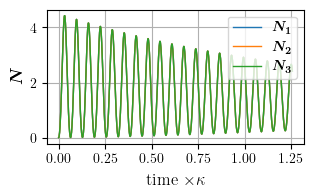

In [20]:
model.evolution_N()

The same can be done for fock state probabilities:

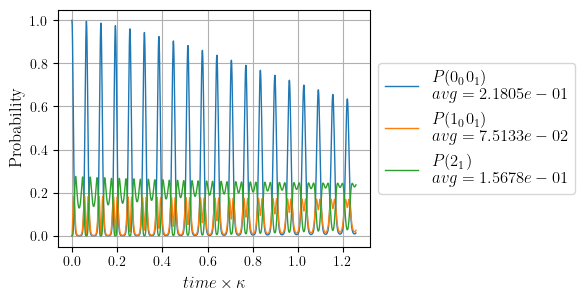

In [21]:
# Each dict key corresponds to a combination of modes
# Each dict value is a list containing different combinations of photon numbers
fock_combs_per_mode_comb = {
    (0, 1): [(0, 0), (1, 0)],
    (1,): [(2,)]
}
model.evolution_fock(fock_combs_per_mode_comb=fock_combs_per_mode_comb)

This tutorial on how the **Qsyst** class works is finished.